# LTEM simulations

Simulation of the defocused LTEM pattern given an omf input 3D magnetisation input on a regular grid in cartesian coordiantes.

Lorentz Tranmission Electron Microscopy (LTEM) is a very useful way to of viewing the component of the magnetic flux density in a thin sample normal to the electron beam.

This code simulates LTEM images and is based on the equations derived in M. Beleggia and Y. Zhu, Phil. Mag. 83, 8, 1045, 2003.

Throughout, we assume the Fourier transform convention that if $f(\mathbf{r})$ is a two-dimensional function in real-space, its Fourier transform is given by:

\begin{equation}
\widetilde{f}(\mathbf{k})=\int f(\mathbf{r})e^{-2\pi i \mathbf{k.r}}d^2\mathbf{r}
\end{equation}

The magnetic contribution to the phase shift $\phi$ the electrons suffer on passing through a sample of thickness $t$ can be calculated from the magnetisation in Fourier space using the following equation:

\begin{equation}
\widetilde{\phi}(k_x,k_y) = \frac{iet\mu_0}{h} \left( \frac{\left[\mathbf{\widetilde{M}_{\bot}}(k_x,k_y)\times \mathbf{k_\bot} \right]_z}{k^2_\bot }\right),
\end{equation}

where $\mathbf{M}_\bot$ is the projected magnetisation, and $t$ is the thickness of the sample. To avoid singularities in Fourier space, a Tikhonov filter is used where $1/k^2$ is replaced by $k^2/(k^2+k_c^2)$ where $k_c$ is the radius of the filter. From the phase any type of image can be simulated.

A common way to plot the field lines of the projected magnetic flux density ($\mathbf{B}_\bot$) is to take the cosine of a multiple of the phase. (See Fig. 1 of M. Beleggia and Y. Zhu, Phil. Mag. 83, 8, 1045, 2003, for example.) The multiplier is called the phase amplification factor $A_{\phi}$.

From the phase, the projected magnetic flux density (i.e. the B-field normal to the electron beam averaged along the trajectory of an unscattered electron) can be the calculated by 

\begin{align}
\mathbf{B}_\bot &= \frac{h}{2\pi e t} \begin{bmatrix} -\frac{\partial}{\partial y} \\ \frac{\partial}{\partial x} \end{bmatrix} \phi.
\end{align} 

The wavefunction of the electron beam as it exits the specimen is

\begin{equation}
\psi_0 = e^{i\phi}.
\end{equation}

The intensity of an in-focus image is $I=|\psi_0|^2=1$ and so the image appears featureless. There are several ways to produce an image showing magnetic contrast and we discuss:

(1) Off-axis electron holography - where the phase is recovered directly and may be compared with the phase calculated below.

(2) Out-of-focus imaging (also called Fresnel imaging).

Out-of-focus images can be simulated by propagating the wavefunction through free-space by a distance $\Delta f$, known as the defocus, using the Fresnel-Kirchoff integral (J. E. Bonevich et al., Phys. Rev. B 49, 10, 6800, 1994, E. Hecht,\emph{Optics} 2nd ed. Addison-Wesley, Reading MA, USA 1974):

\begin{equation}
\psi_{\Delta f} = \psi_0 \ast \left({e^{i\pi r^2/\lambda\Delta f} \over \lambda |\Delta f|}\right)
\end{equation}

This is most easily done in Fourier space as the spherical aberration $C_s$ of the microscope can also be accounted for (D. B. Williams and C. B. Carter, \emph{Transmission Electron Microscopy: A Textbook for Materials Science}, 2nd etdn. Springer Science and Business Media, New York, USA, 2009 p485.):

\begin{equation}
\widetilde{\psi_{\Delta f}} = \widetilde{\psi_{0}}e^{-i(\pi \lambda \Delta f k^2+\frac{1}{2}\pi C_s\lambda^3k^4)}
\end{equation}

where $\Delta f$ is the defocus, and $\lambda$ is the wavelength of the electon beam. The exponential factor is called the contrast transfer function.

The intensity of the out-of-focus image is then given by:

\begin{equation}
I_{\Delta f} = \mid\psi_{\Delta f}\mid^2
\end{equation}

The size of defocus required to give maximum image contrast can be estimated from $\Delta f = L^2/2\lambda$ where $L$ is the size of the skyrmion and $\lambda$ is the electron wavelength (0.00197 nm at 300 kV and 0.00251 nm at 200 kV). The graph at the bottom shows the image contrast versus defocus and the maximum contrast is where the graph starts to level off. As a rule of thumb, the magnetic feature will only be seen using this technique if it gives a contrast greater than 1%. (S.A. Meynell et al., Phys. Rev. B 90, 224419, 2014.)

### Importing Packages

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import random
import matplotlib.pyplot as plt
from ltem_simulation import LTEMSimulation as LTEM

In [2]:
random.seed(1)

### Magnetisation data

Perform micromagnetic simulation or load from file.

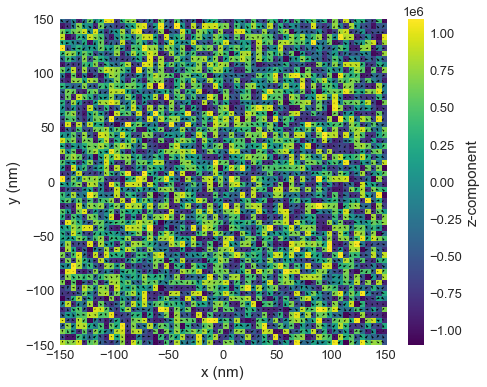

In [3]:
region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box')

system.energy = (mm.Exchange(A=1.6e-11)
               + mm.DMI(D=4e-3, crystalclass='T') 
               + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return [2*random.random()-1 for i in range(3)]  

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

Running OOMMF (ExeOOMMFRunner) [2021/06/09 14:38]... (12.4 s)


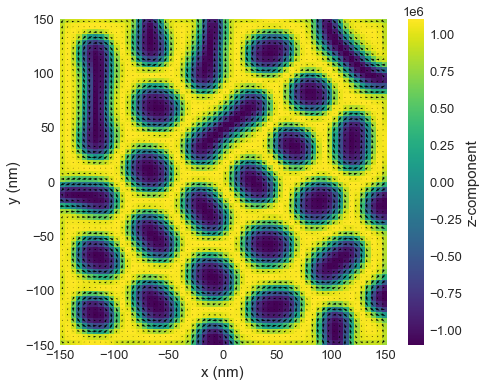

In [4]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

### Projection

The LTEM simulations work with a 2D array of projected magnetisation. For example, if the electron beam was incident in the $z$ direction. 

Find the magnetisation averaged through the specimen thickness

In [5]:
p_mx = np.mean(np.transpose((system.m.x.array[:,:,:,0]), (1,0,2)), axis=2)/Ms
p_my = np.mean(np.transpose((system.m.y.array[:,:,:,0]), (1,0,2)), axis=2)/Ms
p_mz = np.mean(np.transpose((system.m.z.array[:,:,:,0]), (1,0,2)), axis=2)/Ms

In [6]:
system.m.mesh.region.p2

(1.5e-07, 1.5e-07, 2e-08)

In [7]:
system.m.mesh.region.p1

(-1.5e-07, -1.5e-07, 0)

Plot projected magnetisation

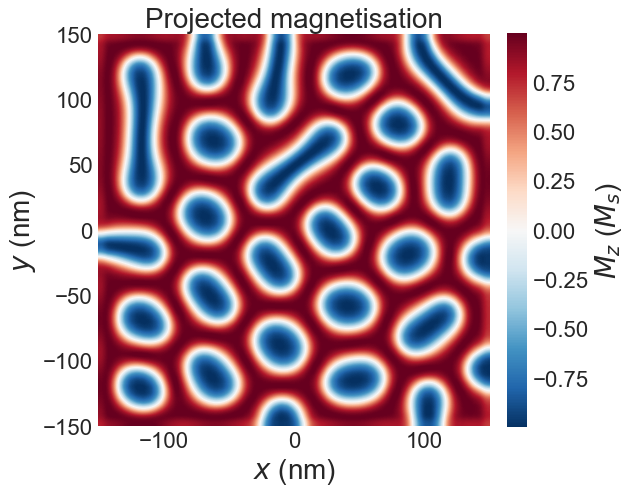

In [8]:
plt.figure(figsize=(8, 8), dpi=80)
plt.title('Projected magnetisation', fontsize=25)
imgplot1 = plt.imshow(p_mz, origin='lower', cmap='RdBu_r', 
                      extent=[(system.m.mesh.region.p1[0])*10**9, (system.m.mesh.region.p2[0])*10**9, (system.m.mesh.region.p1[1])*10**9, (system.m.mesh.region.p2[1])*10**9],
                     interpolation='spline16')
cbar1 = plt.colorbar(imgplot1, fraction=0.046, pad=0.04)
plt.xlabel("$x$ (nm)", fontsize=25)
plt.ylabel("$y$ (nm)", fontsize=25)
plt.tick_params(labelsize=20)
cbar1.ax.set_ylabel(r'$M_z$ ($M_s$)', fontsize=25)
cbar1.ax.tick_params(labelsize=20)
plt.tight_layout()
plt.show()

### Simulate LTEM

Initialise the LTEM simulation by inputting the magnetic and physical parameters.

LTEM(mean mx, mean my, mean mz, step size in x, step size in y, thickness, $M_\text{sat}$)

where averaged mx, and averaged my are given in units of $M_\text{sat}$;
step size in x, step size in y, and thickness are given in nm;
and $M_\text{sat}$ is given in Tesla.

Ms gives the value of $M_\text{sat}$  in A/m and LTEM function requires it in Tesla so it needs to be multiplied by $\mu_0$ 

In [9]:
M_sat = Ms*4*np.pi*1E-7
dx = system.m.mesh.cell[0]*10**9  # MARTIN: use `1e9`
dy = system.m.mesh.cell[2]*10**9  # MARTIN: should be `cell[1]`
thickness = (system.m.mesh.region.edges[2])*10**9

In [10]:
sim = LTEM(p_mx, p_my, p_mz, dx, dy, thickness, M_sat)

### Calculate the phase

The phase is calculated in Fourier space via

\begin{equation}
\widetilde{\phi}(k_x,k_y) = \frac{iet\mu_0}{h} \left( \frac{\left[\mathbf{\widetilde{M}_{\bot}}(k_x,k_y)\times \mathbf{k_\bot} \right]_z}{k^2_\bot }\right)
\end{equation}

and then inverse-transformed.

calculate_phase(acceleration voltage, Cs, Tikhonov filter x, Tikhonov filter y)
Inputs the size of the Tikhonov filter radii in pixels, the acceleration voltage in kV, and the spherical aberation Cs in mm of the microscope.

In [11]:
sim.calculate_phase(300,8000,0.1,0.1)

The electron beam has a wavelength of 1.97E-03 nm.


An array of the phase can be obtained from sim.phase if needed

### Out-of-focus Imaging

The intensity in a defocussed image $\psi_{\Delta f}$ can be simulated by multiplying the in-focus wavefunction $\psi_{0}$ by the contrast transfer function (CTF) in Fourier space:

\begin{align}
\widetilde{\psi_{\Delta f}} & = \widetilde{\psi_{0}}e^{2i\pi(-\frac{1}{2} \lambda \Delta f k^2 +\frac{1}{4} \lambda^3 C_s k^4) }, \\
I_{\Delta f} &= \mid\psi_{\Delta f}\mid^2.
\end{align}

where $\Delta f$ is the defocus, $C_s$ is the spherical aberration coefficient, and $I_{\Delta f}$ is the intensity.

Plots the defocussed image at the defocus specified by the first variable. The intensity has been scaled so infocus there is 1 count per pixel.

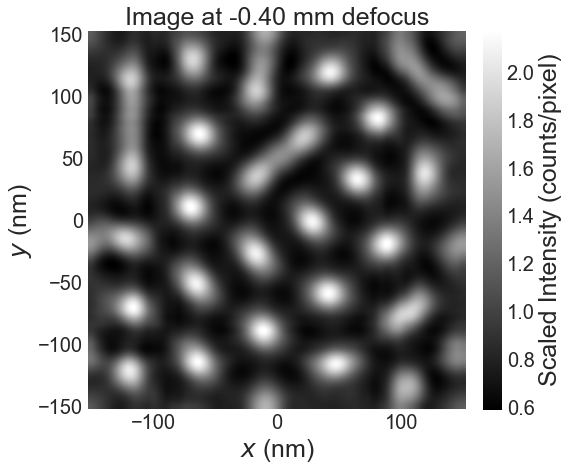

In [12]:
sim.plot_defocus_image(-0.4)

An array of the defocus imagine can be obtained from sim.calculate_defocus_image()

# Extra stuff

Plots the Fourier transform of the phase of the electron wavefunction.

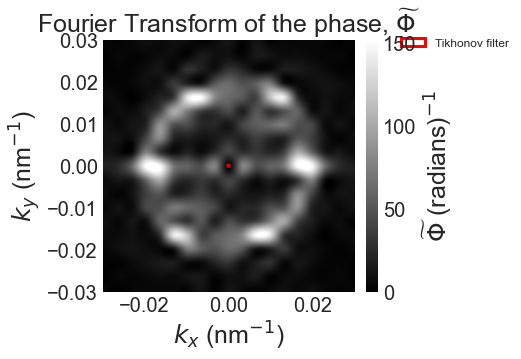

In [13]:
sim.plot_ftphase(plot_limits=[-0.03, 0.03, -0.03, 0.03])

Plots the phase of the electron wavefunction in real space.

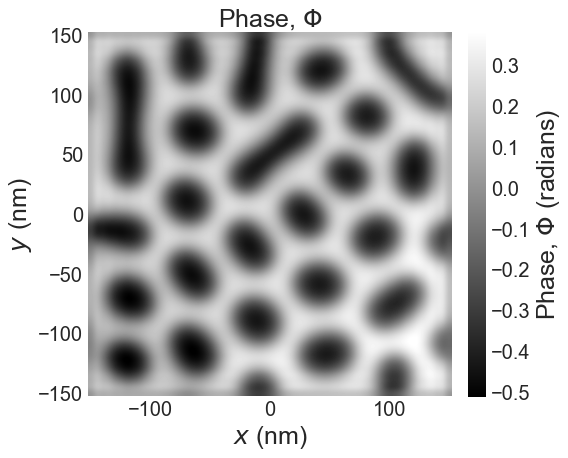

In [14]:
sim.plot_phase()

Magnetic flux density
The magnetic field lines lie along lines of constant phase. 
Plots the cosine of a multiple of the phase of the electron wavefunction.

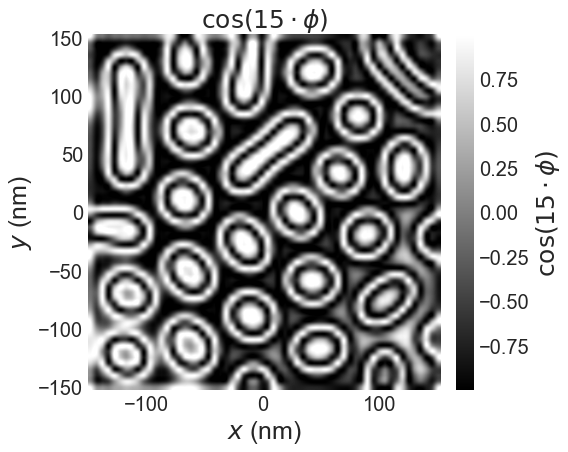

In [15]:
sim.plot_cosine_phase(15)

Projected magnetisation

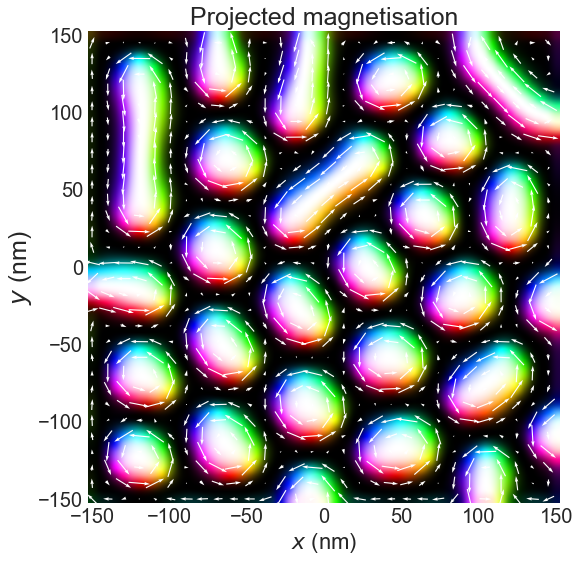

In [16]:
sim.plot_projected_magnetisation(skip_arrow=2, size_arrow=0.05, color='w')

The magnetic field is related to the phase by 
\begin{align}
\mathbf{B} &= \frac{h}{2\pi e t} \begin{bmatrix} -\frac{\partial}{\partial y} \\ \frac{\partial}{\partial x} \end{bmatrix} \phi.
\end{align}

Calculates the projected B-field from the phase.

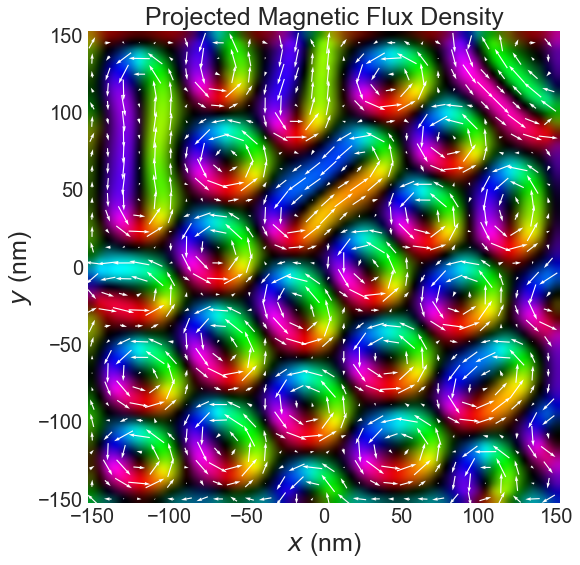

In [17]:
sim.calculate_magnetic_flux_density()
sim.plot_magnetic_flux_density(skip_arrow=2, size_arrow=0.04, color='w')

# Futher Information

For more information contact Sam Holt via S.J.R.Holt@warwick.ac.uk